In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.io.fits as pyfits

import os

#### Ορισμός γεωμετρικών στοιχείων

In [142]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def get_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

origin = Point(0, 0)

class Circle:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def is_point_in_circle(self, point):
        return get_distance(self.center, point) - self.radius <= 0
    
    def are_points_in_circle(self, points):
        return [self.is_point_in_circle(point) for point in points]

#### Δεδομένα φωτογραφίας

In [143]:
event_path = "events/"

event_files = [os.path.join(event_path, f) for f in os.listdir(event_path) if f.endswith(".evt.gz")]
event_number = len(event_files)
#source_fits_file = "source_data.fits.gz"

source_fits_sections = pyfits.open(event_files[event_number - 1])
source_data = source_fits_sections[1].data

#### Προβολή φωτογραφίας

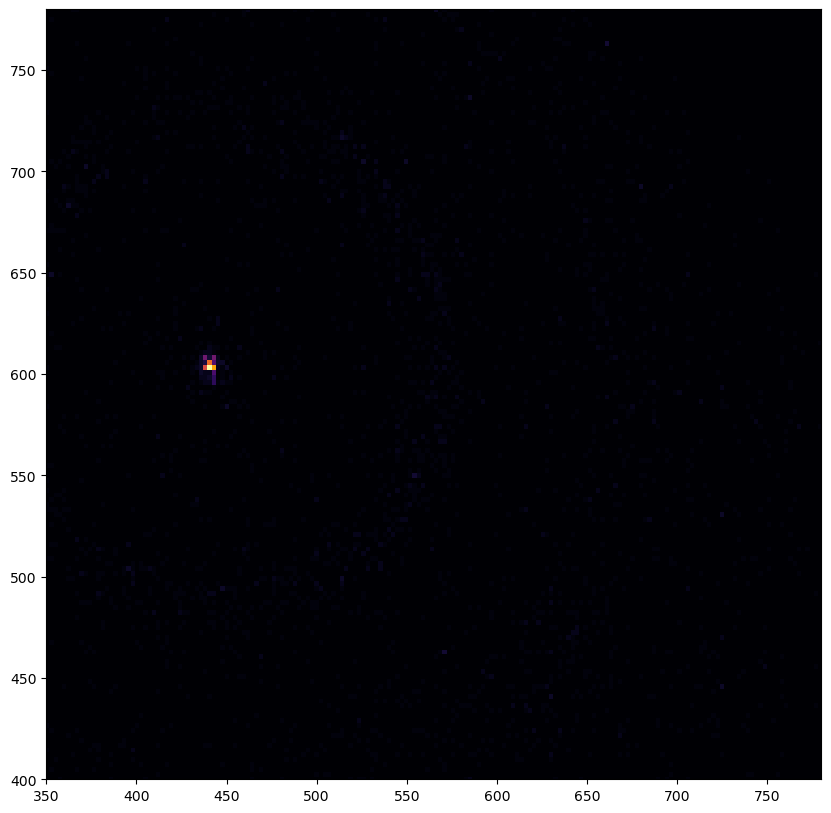

In [141]:
source_x_coords = source_data['X']
source_y_coords = source_data['Y']

source_x_limits = Point(350, 780)
source_y_limits = Point(400, 780)

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(source_x_coords, source_y_coords, bins=300, cmap='inferno')
plt.xlim(source_x_limits.x, source_x_limits.y)
plt.ylim(source_y_limits.x, source_y_limits.y)
plt.show()

#### Ορισμός Γεωμετρικών Χαρακτηριστικών εικόνας

In [138]:
source_center_x = 565
source_center_y = 585
source_radius = 50

source_origin = Point(source_center_x, source_center_y)
source_circle = Circle(source_origin, source_radius)

#### Έλεγχος ορθότητας επιλογής κέντρου

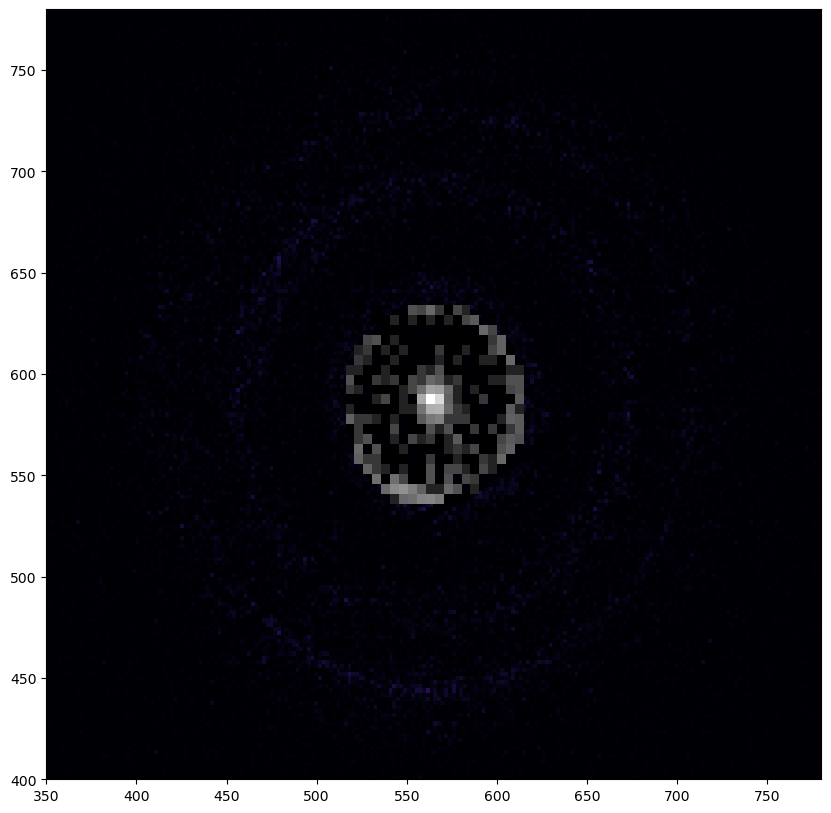

In [139]:
source_points = np.array([Point(x, y) for x, y in zip(source_x_coords, source_y_coords)])

source_origin_mask = source_circle.are_points_in_circle(source_points)

masked_source_points = source_points[source_origin_mask]
masked_source_x_coords = np.array([point.x for point in masked_source_points])
masked_source_y_coords = np.array([point.y for point in masked_source_points])

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(source_x_coords, source_y_coords, bins=300, cmap='inferno')
plt.hist2d(masked_source_x_coords, masked_source_y_coords, bins=20, cmap=plt.cm.gray,norm=mpl.colors.LogNorm())
plt.xlim(source_x_limits.x, source_x_limits.y)
plt.ylim(source_y_limits.x, source_y_limits.y)
plt.show()